# Kalman Filter

> This Tutorial is fetched from [Kalman Filter](https://medium.com/@ab.jannatpour/kalman-filter-with-python-code-98641017a2bd)

Initialize the filter with an initial estimate of the state and the associated uncertainty (covariance)
At each time step:

a. Prediction step: use the model of the system’s dynamics to predict the state of the system at the next time step based on the current estimate of the state
b. Correction step:
i. Compute the Kalman gain, which is a measure of how much the new measurement data should be trusted relative to the prediction

ii. Update the estimate of the state based on the new measurement data and the Kalman gain.

iii. Update the uncertainty (covariance) of the estimate

The output of the filter is the estimated state of the system at each time step.

In [2]:
#| default_exp kalman_filter

In [3]:
#| hide
import numpy as np
from scipy.linalg import inv

In [4]:
#| export
import numpy as np
from nours_notebooks.probabilistic_state_estimation import calculate_B_matrix

# Linear Kalman Filter
class KalmanFilter:
    def __init__(self, transition_matrix:np.array, # system model
                 measurment_matrix:np.array, # measurement model
                 state_estimate:np.array, # initial state
                 state_cov:np.array, # initial state covariance]
                 process_noise_cov:np.array, # process noise covariance
                 measurement_noise_cov:np.array # measurement noise covariance
                 ) -> None:
        self.A = transition_matrix
        self.H = measurment_matrix
        self.x = state_estimate
        self.P = state_cov
        self.Q = process_noise_cov
        self.R = measurement_noise_cov

    def predict(self, dk:float=1.0, # delta time
                u:np.array=np.zeros((2,)), # control inputs 2x1 Numpy Array
                w:np.array=np.zeros((3,)) # process noises, 3x1 NumPy Array
                ) -> None:
        """ 
        Predict the state estimate at time k based on the state 
        estimate at time k-1 and the control input applied at time k-1.
        """
        self.x_predicted = (self.A @ self.x) + (calculate_B_matrix(self.x[2], dk) @ u) + w
        self.P_predicted = self.A @ self.P @ self.A.T + self.Q

    def calculate_y_residual(self, z:np.array, # sensor measurement 3x1 NumPy Array
                                v:np.array # observation noise 3x1 NumPy Array
                             ) -> np.array:
        """
        Calculate the difference between the actual sensor measurements
        at time k minus what the measurement(observation) model predicted.
        the sensor measurements would be for the current timestep k.
        """
        return z - ((self.H @ self.x_predicted) + v)
    
    def calculate_residual_cov(self) -> np.array:
        return self.H @ self.P_predicted @ self.H.T + self.R

    def compute_kalman_gain(self) -> np.array: # Kalman Gain
        """
        Calculate the near-optimal Kalman gain
        We use pseudoinverse since some of the matrices might be
        non-square or singular.
        """
        # innovation covariance
        self.S = self.calculate_residual_cov()
        return self.P_predicted @ self.H.T @ np.linalg.pinv(self.S)

    def update(self, z:np.array, # sensor measurement 3x1 NumPy Array
               v:np.array=np.zeros((3, 1)) # sensor noise 3x1 NumPy Array
               ) -> None:
        """
        Update state estimate for time k.
        Update the state covariance estimate for time k.
        """
        self.y_residual = self.calculate_y_residual(z, v)
        self.K = self.compute_kalman_gain()
        x_estimated = self.x_predicted + (self.K @ self.y_residual)
        P_estimated = self.P_predicted - self.K @ self.H @ self.P_predicted
        self.x = x_estimated
        self.P = P_estimated


Symbolic Jacobian matrix:
⎡cos(x)    2⋅y  ⎤
⎢               ⎥
⎣ 2⋅x    -sin(y)⎦
⎡ 2         ⎤
⎢y  + sin(x)⎥
⎢           ⎥
⎢ 2         ⎥
⎣x  + cos(y)⎦


## Simple Kalman Filter

In [5]:
# Initialize the filter with an initial estimate of the position and the associated uncertainty (covariance)
x_estimated = 0
P_estimated = 1

# Define the velocity and the process noise
velocity = 1
process_noise = 0.1

# Define the measurement noise
measurement_noise = 0.1

for i in range(10):
    # Generate a measurement with some random noise
    measurement = i + np.random.normal(0, measurement_noise)

    # Prediction step
    x_predicted = x_estimated + velocity
    P_predicted = P_estimated + process_noise

    # Correction step
    K = P_predicted / (P_predicted + measurement_noise)
    x_estimated = x_predicted + K * (measurement - x_predicted)
    P_estimated = (1 - K) * P_predicted

    # Print the estimated position
    print("Estimated position: {}".format(x_estimated))

Estimated position: -0.10511427956031394
Estimated position: 0.9818152586890655
Estimated position: 1.9740867719461677
Estimated position: 2.974678961258452
Estimated position: 3.9405528661115192
Estimated position: 4.941625637972043
Estimated position: 5.987559662622105
Estimated position: 7.0568092927812325
Estimated position: 8.125157941515708
Estimated position: 9.122498266140997


## What is the Control Variable Matrix?

The control variable matrix, B, represents the relationship between the control input and the state matrix. The control input is any external inputs that affect the system being modeled, such as a force applied to a moving object. The control variable matrix maps the control input to the state matrix, so that the effect of the control input can be incorporated into the filter’s estimates.

For example, if the system being modeled is a moving object, and the control input is a force applied to the object, the control variable matrix would map the force to the acceleration of the object, so that the filter can estimate the object’s new position and velocity based on the applied force.

The control variable matrix is a matrix of coefficients that multiply the control input to give the effect on the state.

The control variable matrix, B, is defined as a matrix with the same size as the state matrix, and it is multiplied with the control input vector u, to give an effect on the state.

For example, if the system is a simple linear system with 2 states and 1 control input, the state matrix x and control input vector u, the control variable matrix B can be represented as

## What is a Covariance Matrix?

A covariance matrix, also known as a variance-covariance matrix, is a matrix that describes the level of co-variation between different variables in a given dataset. It is often used in statistics and signal processing, including in the Kalman filter.

A covariance matrix is a square matrix of size n x n, where n is the number of variables in the dataset. Each element in the matrix represents the covariance between two variables. The diagonal elements of the matrix represent the variances of each individual variable, and the off-diagonal elements represent the covariances between the different variables.

For example, in the case of a Kalman filter, the covariance matrix, P, represents the uncertainty of the state matrix, x. It describes the co-variation between the different elements of the state matrix, such as position and velocity. The diagonal elements of the matrix represent the variances of the position and velocity estimates, and the off-diagonal elements represent the covariances between the position and velocity estimates.

A standard deviation is a measure of how spread out a dataset is. It is the square root of the variance of a variable.

It is an important concept in Kalman filter as it is used to estimate the uncertainty of the state matrix and also it helps in determining the Kalman gain, which is used in the correction step.

***
$$
P_{predicted} = A \cdot P_{estimated} \cdot A^T + Q
$$
$$
K = P_{predicted} \cdot H^T \cdot (H \cdot P_{predicted} \cdot H^T + R)^{-1}
$$
$$
P_{estimated} = P_{predicted} — K \cdot H \cdot P_{predicted}
$$

***

In [6]:
# Define the data matrix
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Center the data
centered_data = data - np.mean(data, axis=0)

# Calculate the covariance matrix
cov_matrix = np.cov(centered_data.T)

# Calculate the standard deviation
std_dev = np.std(data, axis=0)

print("Covariance matrix: \n", cov_matrix)
print("Standard deviation: \n", std_dev)

Covariance matrix: 
 [[9. 9. 9.]
 [9. 9. 9.]
 [9. 9. 9.]]
Standard deviation: 
 [2.44948974 2.44948974 2.44948974]


## Simple Kalman Filter 2D

In [7]:
# Define time step
dt = 0.1

# Define the initial position, velocity, and acceleration
x0 = 0
v0 = 5
a = -9.8

# Define the state transition matrix
A = np.array([[1, dt], [0, 1]])

# Define the control variable matrix
B = np.array([[0.5*dt**2], [dt]])

# Define the control input
u = np.array([[a]])

# Define the initial state matrix
x_estimated = np.array([[x0], [v0]])

# Define the measurement matrix
H = np.array([[1, 0], [0, 1]])

# Define the measurement noise
R = np.array([[0.1, 0], [0, 0.1]])

# Define the process noise
Q = np.array([[0.01, 0.01], [0.01, 0.02]])

# Define the measurement
measurement = np.array([[x0 + np.random.normal(0, 0.1)], [v0 + np.random.normal(0, 0.1)]])

# Define the estimated covariance
P_estimated = np.eye(2)

for i in range(5):
    # Prediction step
    x_predicted = np.dot(A, x_estimated) + np.dot(B, u)
    P_predicted = np.dot(A, np.dot(P_estimated, A.T)) + Q

    # Correction step
    K = np.dot(P_predicted, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P_predicted, H.T)) + R)))
    x_estimated = x_predicted + np.dot(K, (measurement - np.dot(H, x_predicted)))
    P_estimated = np.dot((np.eye(2) - np.dot(K, H)), P_predicted)

    # Print the estimated position and velocity
    print("Estimated x_position: ", x_estimated[0][0])
    print("Estimated velocity: ", x_estimated[1][0])
    print("Covariance matrix: \n", P_estimated)

Estimated x_position:  0.02018305073379073
Estimated velocity:  5.03082748302432
Covariance matrix: 
 [[0.09098446 0.00088545]
 [0.00088545 0.09098446]]
Estimated x_position:  0.2715569330712122
Estimated velocity:  4.5926247548299735
Covariance matrix: 
 [[0.0500446  0.00473165]
 [0.00473165 0.05215498]]
Estimated x_position:  0.5267185363035549
Estimated velocity:  4.186094211668022
Covariance matrix: 
 [[0.03718643 0.00727804]
 [0.00727804 0.04106952]]
Estimated x_position:  0.7776991873856433
Estimated velocity:  3.8300216217999163
Covariance matrix: 
 [[0.03160685 0.00908047]
 [0.00908047 0.0367094 ]]
Estimated x_position:  1.017912043067356
Estimated velocity:  3.5245287286029527
Covariance matrix: 
 [[0.02881901 0.01033421]
 [0.01033421 0.03468728]]


## Airplane Tracking

A flowchart for a 2-D Kalman filter for tracking an airplane would typically include the following steps:

1. **Initialization**: Define the state matrix, X, which includes the position and velocity of the airplane in the x and y directions. Define the state transition matrix, A, which describes how the state matrix changes over time. Define the measurement matrix, H, which describes how the state matrix is related to the measurement. Define the measurement noise matrix, R, which represents the uncertainty in the measurement. Define the process noise matrix, Q, which represents the uncertainty in the process.

2. **Prediction**: Use the state transition matrix, A, to predict the next state of the system based on the current state. Incorporate the process noise, Q, into the prediction to account for uncertainty.

3. **Measurement Update**: Compare the predicted state matrix with the measurement. Use the Kalman gain, K, to weigh the importance of the prediction and the measurement in the update. Update the state matrix based on the measurement.

4. **Covariance Update**: Update the state covariance matrix, P, based on the measurement and the prediction.

5. **Repeat**: Repeat steps 2–4 at each time step, using the updated state matrix and state covariance matrix as inputs for the next prediction step.


# Extended Kalman Filter

> As a prerequiste, please refer to `State Space Model` and `Observation Model`. To see the implementation details, refer to the source notebook [01_probablistic_state_estimation](01_probablistic_state_estimation.ipynb) and [this blog](https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example).

Consider the following equation

**Next State = 4 * (Current State) + 3**

This is the equation of a line. The regular Kalman Filter can be used on systems like this.

Now, consider this equation

**Next State = Current State + 17 * cos(Current State)**

This equation is nonlinear. If you were to plot it on a graph, you would see that it is not the graph of a straight line. The regular Kalman Filter won’t work on systems like this. So what do we do?

Fortunately, mathematics can help us linearize nonlinear equations like the one above. Once we linearize this equation, we can then use it in the regular Kalman Filter.

If you were to zoom in to an arbitrary point on a nonlinear curve, you would see that it would look very much like a line. With the Extended Kalman Filter, we convert the nonlinear equation into a linearized form using a special matrix called the Jacobian. We then use this linearized form of the equation to complete the Kalman Filtering process.

## EKF Algorithm

**1. Initialization**: 

<p align="center">
  <img src="https://automaticaddison.com/wp-content/uploads/2020/12/ekf46JPG.jpg" alt="robot environment">
</p>

State Estimate:

$$
\hat{x}_{k-1|k-1} = \begin{bmatrix} x_{k-1} \\ y_{k-1} \\ \gamma_{k-1} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}
$$

Control input vector(forward and angular velocties):

$$
u_{k-1} = \begin{bmatrix} v_{k-1} \\ w_{k-1} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}
$$



**2. Predicted State Estimate**

$$
\hat{x}_{k|k-1} = f(\hat{x}_{k-1|k-1}, u_{k})
$$

$$
x_{t} = \hat{x}_{k|k-1} = A_{k-1}x_{k-1} + B_{k-1}u_{k-1}
$$


**3. Predicted Covariance of the State Estimate**

$$
P_{k|k-1} = F_{k} P_{k-1|k-1} F_{k}^{T} + Q_{k}
$$

$$
P_{k-1|k-1} = \begin{bmatrix} 0.1 & 0 & 0 \\  0 & 0.1 & 0 \\ 0 & 0 & 0.1 \end{bmatrix}
$$

$$
F_{k} = A = I_{3}
$$

$$
Q_{k} = \begin{bmatrix} \mathrm{Var}(x) & \mathrm{Cov}(x, y) & \mathrm{Cov}(x, \gamma) \\  \mathrm{Cov}(y, x) & \mathrm{Var}(y) & \mathrm{Cov}(y, \gamma) \\ \mathrm{Cov}(\gamma, x) & \mathrm{Cov}(\gamma, y) & \mathrm{Var}(\gamma) \end{bmatrix}
$$

$$
Q_{k-1|k-1} = I_{3}
$$

`Q` represents how much the actual motion deviates from your assumed state space model. It is a square matrix that has the same number of rows and columns as there are states.

When `Q` is large, the EKF tracks large changes in the sensor measurements more closely than for smaller `Q`. 

In other words, ***when `Q` is large, it means we trust our actual sensor observations more than we trust our predicted sensor measurements from the observation model.***



**4. Innovation or Measurement Residual**

$$
  \tilde{y}_{k} = z_{k} - h(\hat{x}_{k|k-1})
$$

$$
  h(\hat{x}_{k|k-1}) = H_{k}\hat{x}_{k|k-1} + w_{k}
$$

We calculate the difference between actual sensor observations and predicted sensor observations.

- $z_{k}$ is the observation vector. It is a vector of the actual readings from our sensors at time `k`.
- Sensor noise assumption $w_{k}$ ***(which is a vector with the same number of elements as there are sensor measurements)***
- Measurement matrix $H_{k}$ ***(which is used to convert the predicted state estimate at time k into predicted sensor measurements at time k)***

In case, we have a sensor mounted on our mobile robot that is able to make direction measurements of the state `[x,y,yaw angle]`. In this example, `H` is the identity matrix. ***(It has the same number of rows as sensor measurements and same number of columns as the number of states)***

**5. Innovation (or residual) Covariance**

To calculate $S_{k}$, which represents the measurement residual covariance (also known as measurement prediction covariance).

$$
  S_{k} = H_{k} P_{k|k-1} H_{k}^{T} + R_{k}
$$

$R_{k}$ ***(sensor measurement noise covariance matrix…which is a covariance matrix that has the same number of rows as sensor measurements and same number of columns as sensor measurements)***


**6. Near-optimal Kalman Gain**

$$
K_{k} = P_{k|k-1} H_{k}^{T} S_{k}^{-1}
$$

`K` indicates how much the state and covariance of the state predictions should be corrected (see Steps 7 and 8 below) as a result of the new actual sensor measurements ($z_{k}$).

If sensor measurement noise is large, then K approaches 0, and sensor measurements will be mostly ignored.

If prediction noise (using the dynamical model/physics of the system) is large, then K approaches 1, and sensor measurements will dominate the estimate of the state `[x,y,yaw angle]`.


**7. Update State Estimate**

$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_{k} \tilde{y}_{k}
$$

This step answers the all-important question: ***What is the state of the robotic system after seeing the new sensor measurement? It is our best estimate for the state of the robotic system at the current timestep `k`.***

**8. Updated Covariance of the State Estimate**

$$
P_{k|k} = (I - K_{k} H_{k}) P_{k|k-1}
$$

This step answers the question: ***What is the covariance of the state of the robotic system after seeing the fresh sensor measurements?***

In [8]:
#| export
class EKF(KalmanFilter):
    def __init__(self, transition_matrix:np.array, # system model
                 measurement_matrix:np.array, # measurement model
                 state_estimate:np.array, # initial state
                 state_cov:np.array, # initial state covariance]
                 process_noise_cov:np.array, # process noise covariance
                 measurement_noise_cov:np.array, # measurement noise covariance
                 state_transition_jacobian: np.array, # Jacobian of the state transition function
                 measurement_jacobian: np.array # Jacobian of the observation function
                 ) -> None:
    
        super().__init__(transition_matrix,
                       measurement_matrix,
                       state_estimate,
                       state_cov,
                       process_noise_cov,
                       measurement_noise_cov)
        self.A_jacobian = state_transition_jacobian
        self.H_jacobian = measurement_jacobian
        
    def predict(self, dk:float=0.1, # delta time
                u:np.array=np.zeros((2,)), # The control input vector at time k-1 in the global reference frame. [v, yaw_rate]
                w:np.array=np.zeros((3,)) # process noises, 3x1 NumPy Array
                ) -> None:
        super().predict(dk, u, w)

    def update(self, z:np.array, # sensor measurement 1x3 NumPy Array
                v:np.array # sensor noise 3x1 NumPy Array
                ) -> None:
        super().update(z, v)

In [9]:
#| hide
# A matrix
# 3x3 matrix -> number of states x number of states matrix
# Expresses how the state of the system [x,y,yaw] changes 
# from k-1 to k when no control command is executed.
# Typically a robot on wheels only drives when the wheels are told to turn.
# For this case, A is the identity matrix.
# A is sometimes F in the literature.
A_k_minus_1 = np.array([[1.0,  0,   0],
                                                [  0,1.0,   0],
                                                [  0,  0, 1.0]])
 
# Noise applied to the forward kinematics (calculation
# of the estimated state at time k from the state
# transition model of the mobile robot). This is a vector
# with the number of elements equal to the number of states
process_noise_v_k_minus_1 = np.array([0.01,0.01,0.003])
     
# State model noise covariance matrix Q_k
# When Q is large, the Kalman Filter tracks large changes in 
# the sensor measurements more closely than for smaller Q.
# Q is a square matrix that has the same number of rows as states.
Q_k = np.array([[1.0,   0,   0],
                                [  0, 1.0,   0],
                                [  0,   0, 1.0]])
                 
# Measurement matrix H_k
# Used to convert the predicted state estimate at time k
# into predicted sensor measurements at time k.
# In this case, H will be the identity matrix since the 
# estimated state maps directly to state measurements from the 
# odometry data [x, y, yaw]
# H has the same number of rows as sensor measurements
# and same number of columns as states.
H_k = np.array([[1.0,  0,   0],
                                [  0,1.0,   0],
                                [  0,  0, 1.0]])
                         
# Sensor measurement noise covariance matrix R_k
# Has the same number of rows and columns as sensor measurements.
# If we are sure about the measurements, R will be near zero.
R_k = np.array([[1.0,   0,    0],
                                [  0, 1.0,    0],
                                [  0,    0, 1.0]])  
                 
# Sensor noise. This is a vector with the
# number of elements equal to the number of sensor measurements.
sensor_noise_w_k = np.array([0.07,0.07,0.04])

# We start at time k=1
k = 1
    
# Time interval in seconds
dk = 1

# Create a list of sensor observations at successive timesteps
# Each list within z_k is an observation vector.
z_k = np.array([[4.721,0.143,0.006], # k=1
                [9.353,0.284,0.007], # k=2
                [14.773,0.422,0.009],# k=3
                [18.246,0.555,0.011], # k=4
                [22.609,0.715,0.012]])# k=5
                    
# The estimated state vector at time k-1 in the global reference frame.
# [x_k_minus_1, y_k_minus_1, yaw_k_minus_1]
# [meters, meters, radians]
state_estimate_k_minus_1 = np.array([0.0,0.0,0.0])
    
# The control input vector at time k-1 in the global reference frame.
# [v, yaw_rate]
# [meters/second, radians/second]
# In the literature, this is commonly u.
# Because there is no angular velocity and the robot begins at the 
# origin with a 0 radians yaw angle, this robot is traveling along 
# the positive x-axis in the global reference frame.
control_vector_k_minus_1 = np.array([4.5,0.0])
    
# State covariance matrix P_k_minus_1
# This matrix has the same number of rows (and columns) as the 
# number of states (i.e. 3x3 matrix). P is sometimes referred
# to as Sigma in the literature. It represents an estimate of 
# the accuracy of the state estimate at time k made using the
# state transition matrix. We start off with guessed values.
P_k_minus_1 = np.array([[0.1,  0,   0],
                                                [  0,0.1,   0],
                                                [  0,  0, 0.1]])
                            
# Start at k=1 and go through each of the 5 sensor observations, 
# one at a time. 
# We stop right after timestep k=5 (i.e. the last sensor observation)
ekfObj = EKF(transition_matrix = A_k_minus_1,
            measurement_matrix = H_k,
            state_estimate = state_estimate_k_minus_1,
            state_cov = P_k_minus_1,
            process_noise_cov = Q_k,
            measurement_noise_cov = R_k,
            state_transition_jacobian = np.zeros((1,1)),
            measurement_jacobian = np.zeros((1,1)))

v = sensor_noise_w_k
w = process_noise_v_k_minus_1

for k, obs_vector_z_k in enumerate(z_k,start=1):
    
    # Print the current timestep
    print(f'Timestep k={k}')  
    
    ekfObj.predict(dk, control_vector_k_minus_1, w)
    ekfObj.update(obs_vector_z_k, v)
    print(f'State Estimate Before EKF={ekfObj.x_predicted}')
    print(f'Observation={obs_vector_z_k}')
    print(f'State Estimate After EKF={ekfObj.x}')
    print()


Timestep k=1
State Estimate Before EKF=[4.51e+00 1.00e-02 3.00e-03]
Observation=[4.721 0.143 0.006]
State Estimate After EKF=[ 4.58385714  0.043      -0.01638095]

Timestep k=2
State Estimate Before EKF=[ 9.0932534  -0.02071099 -0.01338095]
Observation=[9.353e+00 2.840e-01 7.000e-03]
State Estimate After EKF=[ 9.20781739  0.12100131 -0.02522642]

Timestep k=3
State Estimate Before EKF=[13.71638562  0.01749448 -0.02222642]
Observation=[1.4773e+01 4.2200e-01 9.0000e-03]
State Estimate After EKF=[14.32408288  0.22353049 -0.02763043]

Timestep k=4
State Estimate Before EKF=[18.83236525  0.10920935 -0.02463043]
Observation=[1.8246e+01 5.5500e-01 1.1000e-02]
State Estimate After EKF=[18.42690971  0.34134596 -0.02732964]

Timestep k=5
State Estimate Before EKF=[22.93522927  0.22837789 -0.02432964]
Observation=[2.2609e+01 7.1500e-01 1.2000e-02]
State Estimate After EKF=[22.69036377  0.48584594 -0.02659788]



## Extended Kalman Filter (EKF) Localization with unknown correspondences

$$
    \mu_{t} = \begin{bmatrix} x_{t} \\ y_{t} \\ \theta_{t} \end{bmatrix} \quad \text{is the state}
$$

$$
    \Sigma_{t} = \begin{bmatrix} \mathrm{Var}(x) & \mathrm{Cov}(x, y) & \mathrm{Cov}(x, \theta) \\
                \mathrm{Cov}(y, x) & \mathrm{Var}(y) & \mathrm{Cov}(y, \theta) \\
                \mathrm{Cov}(\theta, x) & \mathrm{Cov}(\theta, y) & \mathrm{Var}(\theta) \end{bmatrix} \quad \text{is the state covariance}
$$

**1. Predict**

$$
\overline{\mu}_{t} = \mu_{t-1} + u
$$

$$
\overline{\Sigma}_{t} = G_{t} \Sigma_{t-1} G_{t}^{T} + R_{t}
$$

where

$$
    \overline{\mu}_{t} \quad \text{is the predicted state} \\
    \mu_{t-1} \quad \text{ is current state} \\
    u = \Delta \mu_{t} \quad \text{ is delta motion} \\
    \overline{\Sigma}_{t} \quad \text{is the predicted state covariance} \\
    R_{t} \quad \text{is the procss noise covariance} \\
    G_{t} = I_{3} \\

$$

**2. Maximum Likelihood Correspondence**

The EKF localization discussed thus is only applicable when landmark correspondences can be determined with absolute certainty. In practice, this is rarely the case.
Most implementations therefore determine the identity of the landmark during localization. Throughout this book, we will encounter a number of strategies to cope with
the correspondence problem. The most simple of all is known as _maximum likelihood correspondence_, **in which one first determines the most likely value of the correspon-
dence variable, and then takes this value for granted.**

<b><span style="color: red;">To reduce the danger of asserting a false data association, there exist essentially two techniques:</span></b> 

- First, select landmarks that are sufficiently unique and sufficiently far apart from each other that confusing them with each other is unlikely.
- Second, make sure that the robot’s pose uncertainty remains small.

The correspondence variable is then chosen by minimizing a quadratic Mahalanobis distance function
defined over the measured feature vector $z_{t}^{i}$ and the expected measurement $ẑ_{t}$

$$
j(i) = \underset{k}{\arg\min} (z_{t}^{i} - \hat{z}^{k}_{t})^T \Psi^{-1}_{j(i)} (z_{t}^{i} - \hat{z}^{k}_{t})
$$

$$
Q_t = \begin{bmatrix} \sigma_r && 0 && 0 \\ 0 && \sigma_\phi && 0 \\ 0 && 0 && \sigma_s\end{bmatrix} \quad \text{is the innovation noise covariance}
$$

_for all landmarks `k` in the map `m` do_

$$
    \delta_{t} = \begin{bmatrix} \delta_{k,x} \\ \delta_{k,y} \end{bmatrix} = \begin{bmatrix} m_{k,x} - \overline{\mu}_{t,x} \\ m_{k,y} - \overline{\mu}_{t,y} \end{bmatrix}
$$

$$
    q_{k} = \delta_{k}^{T} \delta_{k}
$$

$$
    ẑ_{t}^{k} = \begin{bmatrix} \sqrt{q_{k}} \\ atan2(\delta_{k,y}, \delta_{k,x}) - \overline{\mu}_{t,\theta} \\ m_{k,s} \end{bmatrix}
$$

$$
    H_{t}^{k} = \frac{1}{q_k} \begin{bmatrix} \sqrt{q_{k}}\delta_{k,x} && -\sqrt{q_{k}}\delta_{k,y} && 0 \\ \delta_{k,y} && \delta_{k,x} && -1 \\ 0 && 0 && 0 \end{bmatrix} \quad \text{is the observation matrix}
$$

$$
    \Psi_k = H_{t}^{k} \overline{\Sigma}_{t} [H_{t}^{k}]^T + Q_t \quad \text{is the innovation covariance}
$$

_for all observed features $z_{t}^{i} = (r_{t}^{i} \phi_{t}^{i} s_{t}^{i})^{T}$ do_

$$
j(i) = \underset{k}{\arg\min} (z_{t}^{i} - \hat{z}^{k}_{t})^T \Psi^{-1}_{j(i)} (z_{t}^{i} - \hat{z}^{k}_{t}) \\
K_{t}^{i} = \overline{\Sigma}_{t} [H_{t}^{j(i)}]^T \Psi_{j(i)}^{-1}
$$

**3. Update**
$$
    \mu_t =  \overline{\mu}_{t} + \sum_{i}{K_{t}^{i} (z_{t}^{i} - ẑ_{t}^{j(i)})} \\
    \Sigma_{t} = (I - \sum_{i}{K_{t}^{i} H_{t}^{j(i)}})\overline{\Sigma}_{t}
$$

In [10]:
#| export
z_state = 3
x_state = 3
def ekf_localization(mu, sigma, u, zs, m, R, Q):
    '''
    EKF localization with unknown correspondences.

    Parameters
    ----------
    mu
        The current state estimate, [x y theta], 3x1 NumPy array.
    sigma
        The state covariance, 3x3 NumPy array.
    u
        The delta motion, 3x1 Numpy array.
    zs
        Observed features, Nx3 Numpy array of N observations and [r phi s], namely range, bearing and signature.
    m
        Landmark points, Mx3 Numpy array of M landmarks. [x y s] 2D position and signature.
    R
        Process noise, 3x1 NumPy array, [sigma_x, sigma_y, sigma_theta].
    Q
        Observation noise, 3x1 NumPy array, [sigma_r sigma_phi sigma_s].

    Returns
    -------
    mu_updated
        The updated state.
    sigma_updated
        The updated state covariance.
    '''
    # Predict
    mu_predicted = mu + u
    sigma_predicted = sigma + np.eye(x_state) @ R
    n_map_points = len(m)

    # Initialize variables for storing Jacobians and expected observations
    H = [np.zeros((z_state, x_state)) for map_idx in range(n_map_points)]
    z_expected = [np.zeros((z_state,)) for map_idx in range(n_map_points)]
    psi = [np.zeros((z_state, z_state)) for map_idx in range(n_map_points)]

    x_predicted = mu_predicted[0]
    y_predicted = mu_predicted[1]
    theta_predicted = mu_predicted[2]

    for k, landmark in enumerate(m):
        m_kx = landmark[0]
        m_ky = landmark[1]
        m_ks = landmark[2]
        delta_k = np.array([m_kx - x_predicted, m_ky - y_predicted]) # x, y difference between the map point k, and predicted state.
        delta_kx = delta_k[0]
        delta_ky = delta_k[1]
        q_k = delta_k.T @ delta_k # distance squared

        z_expected[k] = np.array([np.sqrt(q_k), np.arctan2(delta_ky, delta_kx) - theta_predicted, m_ks])
        H[k] = 1 / q_k * np.array([
            [np.sqrt(q_k)* delta_kx, -np.sqrt(q_k)* delta_ky, 0],
            [delta_ky, delta_kx, -1],
            [0, 0, 0]])
        psi[k] = H[k] @ sigma_predicted @ H[k].T + np.eye(z_state) @ Q

    # Update
    mu_updated = mu_predicted.copy() # final state etsimate holder

    # Accumulate Kalman gain times residual matrix
    residual_gain_sum = np.zeros_like(mu_predicted)

    # Accumulate Kalman gain times observation matrix
    KH_sum = np.zeros_like(sigma_predicted)

    for z_observed in zs:
        # Maximum Likelihood Correspondence
        ji = []
        for k in range(n_map_points):
            z_residual = z_observed - z_expected[k]
            psi_k = psi[k]
            likelihood = z_residual.T @ np.linalg.inv(psi_k) @ z_residual
            ji.append(likelihood)

        i = ji.index(min(ji)) # find the index of the minimum chi-square distance
        K_i = sigma_predicted @ H[i].T @ np.linalg.inv(psi[i])
        z_associated = z_expected[i]

        residual_gain_sum += + K_i @ (z_observed - z_associated)
        KH_sum += K_i @ H[i]
    
    # Final state and covariance update
    sigma_updated = (np.eye(x_state) - KH_sum) @ sigma_predicted
    mu_updated = mu_predicted + residual_gain_sum

    return mu_updated, sigma_updated


In [11]:
# Initial state estimate [x, y, theta]
mu = np.array([2.0, 2.0, np.pi/4])

# Initial covariance estimate
sigma = np.array([
    [0.01, 0, 0],
    [0, 0.01, 0],
    [0, 0, 0.01]
])

# Control input [delta_x, delta_y, delta_theta]
u = np.array([0.1, 0.2, 0.1])

# Observed features [range, bearing, signature]
zs = np.array([
    [1.0, np.pi/6, 0],  # Observation 1
    [1.2, np.pi/3, 0]
])

# Landmark points [x, y, signature]
m = np.array([
    [2.3, 3, 1],  # Landmark 1
    [1.7, 3.16, 2]   # Landmark 2
])

# Process noise
R = np.diag([0.1, 0.1, 0.01])

# Observation noise
Q = np.diag([0.1, 0.1, 0.1])

# Call the EKF localization function
mu_updated, sigma_updated = ekf_localization(mu, sigma, u, zs, m, R, Q)

print("Current State Estimate (mu):", mu)
print("Current Covariance Estimate (sigma):", sigma)

print("Updated State Estimate (mu):", mu_updated)
print("Updated Covariance Estimate (sigma):", sigma_updated)

Current State Estimate (mu): [2.         2.         0.78539816]
Current Covariance Estimate (sigma): [[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]
Updated State Estimate (mu): [2.46270251 1.99330472 0.81886796]
Updated Covariance Estimate (sigma): [[-0.00659153 -0.00033836  0.02495746]
 [-0.00033836 -0.00532268  0.00623936]
 [ 0.02495746  0.00623936  0.01432785]]


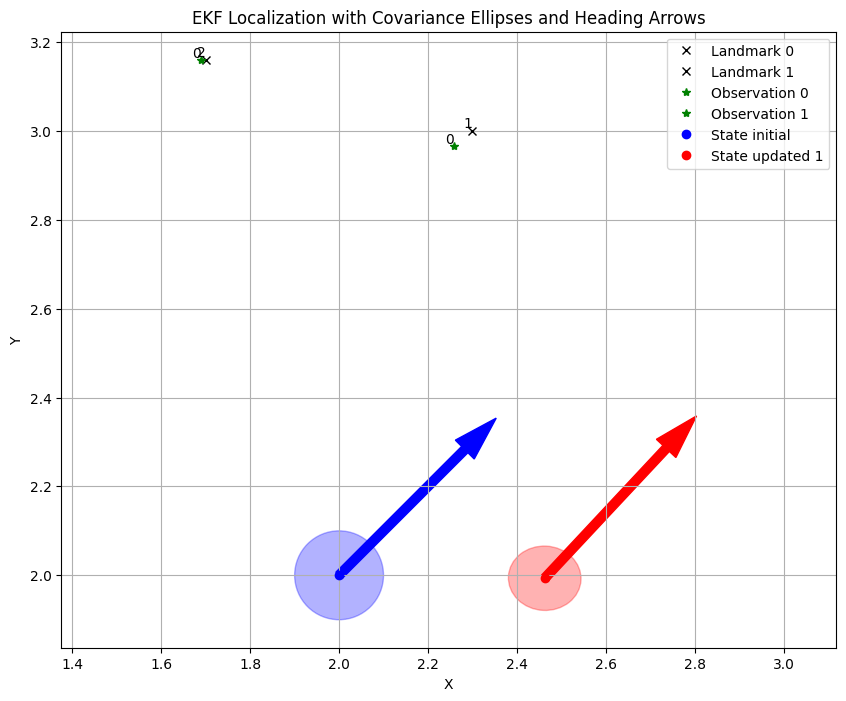

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import numpy.linalg as linalg
import math

# Function to plot state with covariance ellipse
def plot_state_with_covariance(mu, sigma, color='blue', label='inital'):
    # Plot state position
    plt.plot(mu[0], mu[1], 'o', color=color, label='State {}'.format(label))
    U,s,v = linalg.svd(sigma[:2,:2])
    angle = math.atan2(U[1,0],U[0,0])
    
    width  = math.sqrt(s[0]) * 2
    height = math.sqrt(s[1]) * 2

    ellipse = Ellipse((mu[0], mu[1]), width=width, height=height,
                      angle=angle, color=color, alpha=0.3)
    plt.gca().add_patch(ellipse)

    # Add arrow to indicate heading
    arrow = plt.Arrow(mu[0], mu[1], 0.5 * np.cos(mu[2]), 0.5 * np.sin(mu[2]), color=color, width=0.1)
    plt.gca().add_patch(arrow)

# Function to plot the state and observations with ellipses representing covariances and arrows indicating the heading
def plot_ekf_with_covariance_arrows(mu, sigma, mu_updated, sigma_updated, landmarks, observations):
    plt.figure(figsize=(10, 8))

    # Plot landmarks
    for idx, landmark in enumerate(landmarks):
        plt.plot(landmark[0], landmark[1], 'kx', label='Landmark {}'.format(idx))
        plt.text(landmark[0], landmark[1], int(landmark[2]), verticalalignment='bottom', horizontalalignment='right')

    # Plot observations
    for idx, observation in enumerate(observations):
        # Convert polar coordinates to Cartesian coordinates
        x = mu[0] + observation[0] * np.cos(observation[1] + mu[2])
        y = mu[1] + observation[0] * np.sin(observation[1] + mu[2])
        plt.plot(x, y, 'g*', label='Observation {}'.format(idx))
        plt.text(x, y, int(observation[2]), verticalalignment='bottom', horizontalalignment='right')

    # Plot initial state with covariance ellipse
    plot_state_with_covariance(mu, sigma, color='blue', label='initial')

    # Plot updated state with covariance ellipse
    plot_state_with_covariance(mu_updated, sigma_updated, color='red', label='updated 1')

    plt.legend()
    plt.title('EKF Localization with Covariance Ellipses and Heading Arrows')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')  # Ensure equal aspect ratio
    plt.show()

# Convert observations to Cartesian coordinates
def observation_to_cartesian(observation, robot_state):
    range_, bearing, _ = observation
    x_robot, y_robot, theta_robot = robot_state
    x_observation = x_robot + range_ * np.cos(bearing + theta_robot)
    y_observation = y_robot + range_ * np.sin(bearing + theta_robot)
    return x_observation, y_observation

# Call the plot function with covariance ellipses and arrows
# mu_updated, sigma_updated = ekf_localization(mu_updated, sigma_updated, u, zs, m, R, Q)
plot_ekf_with_covariance_arrows(mu, sigma, mu_updated, sigma_updated, m, zs)


In [14]:
abs(sigma_updated[:2,:2])

array([[0.00659153, 0.00033836],
       [0.00033836, 0.00532268]])

# From Polar to Cartesian coordinates

In [15]:
import numpy as np

# Given state of the robot: [x, y, heading]
state = np.array([2.0, 2.0, np.pi/4])

# Given observations: [range, bearing, observation_number]
observations = np.array([
    [1.0, np.pi/6, 1],  # Observation 1
    [1.2, np.pi/3, 2]   # Observation 2
])



# Calculate Cartesian coordinates for each observation
for observation in observations:
    x_obs, y_obs = observation_to_cartesian(observation, state)
    print("Observation:", observation[2])
    print("Cartesian coordinates:", [x_obs, y_obs])


Observation: 1.0
Cartesian coordinates: [2.2588190451025207, 2.9659258262890686]
Observation: 2.0
Cartesian coordinates: [1.6894171458769751, 3.159110991546882]


# Visualization using plotly

In [19]:
import plotly.graph_objects as go
import numpy as np

# Generate sample data for multiple frames
num_frames = 10
points_per_frame = 5

# Generate random data for each frame
x_data = [np.random.rand(points_per_frame) for _ in range(num_frames)]
y_data = [np.random.rand(points_per_frame) for _ in range(num_frames)]

# Create the initial figure
fig = go.Figure()

# Add the initial trace with all points from the first frame
fig.add_trace(go.Scatter(x=x_data[0], y=y_data[0], mode='markers'))

# Create frames for the animation
frames = []
x_accumulated = []
y_accumulated = []

for k in range(num_frames):
    x_accumulated.extend(x_data[k])
    y_accumulated.extend(y_data[k])
    frames.append(go.Frame(data=[go.Scatter(x=x_accumulated, y=y_accumulated, mode='markers')],
                           name=f'frame{k}'))

# Update the layout to add animation controls
fig.update_layout(
    updatemenus=[{
        'type': 'buttons',
        'buttons': [{
            'label': 'Play',
            'method': 'animate',
            'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}]
        }]
    }]
)

# Set the frames for the animation
fig.frames = frames

# Show the figure
fig.show()


In [17]:
#| hide
import nbdev; nbdev.nbdev_export()